# PaddleOCR 多语言模型训练教程

PaddleOCR 提供了 80 种语言模型，但仍然无法覆盖全部。发布的模型可以通过使用自己的识别数据进行微调来达到更好的效果。如果您有以下问题：

- 测试原始识别模型时效果不佳
- 缺乏数据，对训练过程感到困惑
- 不知道如何替换或修改词典

本教程将帮助您学习如何合成识别图像来训练自定义识别模型，具体包括：
- 语料合成可以提高某一类别的识别结果，以泰语为例
- 使用您自己的词典和语料来训练模型，如纯数字模型、多语言模型等。
- 分步训练指南，包括如何通过 `.yml` 配置文件配置训练参数
- 将训练好的模型导出到推理模型

<img src='https://user-images.githubusercontent.com/50011306/184822349-c214e8b7-90f5-4bab-9833-978b5055af04.png' width="600" heith="600">

任何问题关于本教程的讨论可以在 [PaddleOCR's GitHub Discussion](https://github.com/PaddlePaddle/PaddleOCR/discussions) 中进行。

## Environment preparation

In [ ]:
# install paddlepaddle and paddleocr whl package
# !pip install -U pip
!pip install paddlepaddle paddleocr
!git clone https://github.com/PaddlePaddle/PaddleOCR

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112.5 MB 50 kB/s 
     |████████████████████████████████| 334 kB 56.5 MB/s 
     |████████████████████████████████| 394 kB 58.5 MB/s 
     |████████████████████████████████| 604 kB 55.3 MB/s 
     |████████████████████████████████| 2.8 MB 41.8 MB/s 
     |████████████████████████████████| 55.7 MB 1.1 MB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
     |████████████████████████████████| 399 kB 65.0 MB/s 
     |████████████████████████████████| 204 kB 74.9 MB/s 
     |████████████████████████████████| 2.3 MB 46.3 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149870 sha256=13e0c0f3322ef2cbbe613bb8949dcf246b2ddfecfc4c8eb008a2d8c68903b3c9
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Lev

In [ ]:
# data synthesis tool
!git clone https://github.com/tink2123/text_renderer.git

Cloning into 'text_renderer'...
remote: Enumerating objects: 627, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 627 (delta 12), reused 41 (delta 11), pack-reused 580
Receiving objects: 100% (627/627), 13.75 MiB | 18.03 MiB/s, done.
Resolving deltas: 100% (318/318), done.


### 安装第三方要求

In [ ]:
!cd PaddleOCR && pip install -r requirements.txt

In [ ]:
!pip install -r ./text_renderer/requirements.txt

### 快速使用

首先我们展示 paddleocr WHL 包的使用方法。如果您想了解如何使用 WHL 包，请查看[本教程](https://colab.research.google.com/drive/1_GpuvV0eO10TeTX1aCbVFc3aWK5cVcBC?usp=sharing)。

In [ ]:
!paddleocr --image_dir /your/image/path --lang=en

## 数据准备

训练一个识别模型总是需要大量的识别图像，比如 0.1 到 100 万张。除了现有的数据集之外，一般很难获得这么多的真实数据，因此合成数据往往在扩充数据量方面起着重要作用。另一方面，如果只有合成数据，模型的泛化能力可能不够强。在实际训练过程中，按一定比例采样真实数据和合成数据往往是更好的方法。

### 真实数据标注

我们推荐使用 [PPOCRLabel](https://github.com/PaddlePaddle/PaddleOCR/tree/release/2.5/PPOCRLabel) 作为 OCR 任务的标注工具，因为它内置了 PP-OCR 模型，可以自动检测和重新识别数据，效率可提高 50% 以上。

更多信息请阅读 [PPOCRLabel 的 README](https://github.com/PaddlePaddle/PaddleOCR/tree/release/2.5/PPOCRLabel)

<img src='https://github.com/PaddlePaddle/PaddleOCR/raw/release/2.5/PPOCRLabel/data/gif/steps_en.gif' width="600" heith="600">

### 合成数据

数据合成工具：

合成识别图像需要五个元素：词典、语料、字体、背景图片、文本图片生成器工具（推荐[text_renderer](https://github.com/Sanster/text_renderer)，适用于多种语言），然后通过间距、横竖、弯曲等配置来控制最终的效果，使合成图像能够近似真实图像。

接下来我们依次介绍如何获取这些元素。

##### 词典和语料库

词典对应模型需要识别的文本信息，也就是说需要识别的文本都应该在词典中出现。语料库是生成文本图片所需要的单词和句子，合成工具会根据语料库来合成文本图片。

PaddleOCR 中的词典文件和语料文件都是 .txt 格式。

例如部分缅甸语语词典如下：
```
က
ခ
ဂ
ဃ
င
စ
ဆ
ဇ
ဈ
ဉ
ည
ဋ
ဌ
ဍ
ဎ
```

部分缅甸语语语料库如下：

```
လင်းတငှက်တို့သည်
လူသေကောင်ပုပ်ကိုရှာကြသည်။
ပုထုဇဉ်တို့သည်
လူရှင်ကောင်ပုပ်ကိုရှာကြသည်။
သူတော်ကောင်းတို့သည်
အသင်္ခတဓာတ်ကိုရှာကြသည်။
၁၁။ဝန်မလေးမှုသုံးမျိုး
အကိုင်းကိုကန်ရန်ဝန်မလေးဘူး။
သခင်ကိုကန်ရန်ဝန်မလေးဘူး။
```

获取词典和语料库有三种方式

- 从 PaddleOCR github 仓库下载

PaddleOCR 在 [github 仓库](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.8/ppocr/utils/dict) 中发布了一系列词典，用于训练 PP-OCR 多语言模型（训练好的模型可以在 [此处](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.5/doc/doc_en/models_list_en.md#23-multilingual-recognition-modelupdating) 找到）。同时，许多开发者通过 PR 或 [多语言 OCR 发展计划](https://github.com/PaddlePaddle/PaddleOCR/issues/1048) 问题下的评论贡献了部分语言的词典和语料库。

- 自定义词典或语料库

以上词典往往用于通用场景，而其他场景需要的字符是特定的，或者通用词典中的字符不是全部都需要，因此可以根据场景自定义词典的内容。比如你只想识别数字，你的词典就只包含0-9。

如果你想有针对性地提高某些效果，比如空格、特殊符号、标点符号等，可以在构建语料库时多添加这些信息

- 通过语料库获取词典

第三种方法是根据语料库准备词典。这种方法适合先准备语料库内容，通过算法遍历语料库内容，生成包含语料库中所有单词的词典。




#### 字体和背景

当模型识别一些没见过的字体形式（比如点阵字体、数码管字体）时，可能会出现不好的效果，所以需要合成类似字体的数据。

你可以在字体网站找到不同类型的字体。

合成数据的背景应该与真实数据相似。如果你针对特定场景训练模型，你可以直接从真实数据中抓取背景图像。例如，在PCB场景中，图像都是绿色的，这就需要一张类似的绿色图像作为背景。

如果场景中的背景不均匀，你也可以使用ImageNet中的数据作为背景图像

<img src='https://github.com/tink2123/text_renderer/blob/master/data/bg/%E8%83%8C%E6%99%AF.png?raw=true' width="200" heith="200">

#### 开始合成

使用`text_renderer`的方法很简单，只需要将`fonts_list`，`chars_file`指定为字体和字典的路径即可

将准备好的语料库、词典、背景图放在text_renderer/data目录下，并修改默认配置，以英文数据为例。
1. 准备[thai_movies.txt](/content/text_renderer/data/en_corpus/en_movies.txt)中列出的`n`个语料库
2. 如果要增强数据丰富度，可以准备一些背景图放在`data/bg路径`下，本例提供了5张imagenet。
3. 修改`text_renderer/parse_args.py`中的默认参数：`--chars_file`、`--fonts_list`、`--corpus_dir`、`--corpus_mode`

启动数据合成脚本

In [ ]:
!cd text_renderer && python main.py --num_img=10

Total fonts num: 1
Background num: 6
Loading corpus from: ./data/en_corpus
Load corpus: ./data/en_corpus/en_movies.txt
Total lines: 25
Generate text images in ./output/default
10/10 100%
Finish generate data: 1.224 s


合成数据存储在“output/default”目录中。

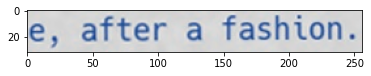

In [ ]:
import cv2
import matplotlib.pyplot as plt

raw_img = cv2.imread("/content/text_renderer/output/default/00000000.jpg")
plt.imshow(raw_img)

另外，可用于训练 PaddleOCR 的真实信息存储在 `output/default/label.txt` 中

```
train_data/rec/train/000000000.jpg	ူးဆို
train_data/rec/train/000000001.jpg	ပမာဏတိုးမ
train_data/rec/train/000000002.jpg	ပဲ၊ပဲစင
train_data/rec/train/000000003.jpg	ပတင်ပို
train_data/rec/train/000000004.jpg	င်ယူပါ။
train_data/rec/train/000000005.jpg	္ဒိမာ၈ဗီ
train_data/rec/train/000000006.jpg	ခန်းတွ
train_data/rec/train/000000007.jpg	တ်ညစ်နေ
train_data/rec/train/000000008.jpg	ေးကြီးခ
...
```

### 缅甸语数据

由于合成过程较长，需要自己准备好数据集。


In [ ]:
!mkdir /content/PaddleOCR/train_data
!cp /gdrive/MyDrive/th_img.tar /content/PaddleOCR/train_data/

mkdir: cannot create directory ‘/content/PaddleOCR/train_data’: File exists


In [ ]:
!cd /content/PaddleOCR/train_data/ && tar -xf bm_img.tar
%cd /content/PaddleOCR

PaddleOCR 要求的标注格式是使用 `\t` 来分割图片路径和图片标签，如果使用其他方式分割，会造成训练误差

### 数据集结构

当您使用自己的数据进行训练时，请参考以下内容来组织文件结构。

- 训练集

建议将训练图像放在同一个文件夹中，并使用一个txt文件（例如`rec_gt_train.txt`）存储图像路径和标签。`rec_gt_train.txt`的格式如上。txt文件的内容如下：

最终的训练集应该具有以下文件结构：

```
|-train_data
|-rec
|- rec_gt_train.txt
|- train
|- word_001.png
|- word_002.jpg
|- word_003.jpg
| ...
```

- 测试集

与训练集类似，测试集也需要提供一个包含所有图像的文件夹（test）和一个rec_gt_test.txt。测试集的结构如下：

```
|-train_data
|-rec
|-ic15_data
|- rec_gt_test.txt
|- test
|- word_001.jpg
|- word_002.jpg
|- word_003.jpg
| ...
```

## 模型训练与评估

PaddleOCR 将训练参数以配置文件的形式传入（包括模型结构、训练配置等），下面是一个典型的配置文件形式。

我们对下面一些重要的参数进行了注释，更多配置可以在 `/config/` 中找到

如果需要添加新的配置文件，请参考下面的示例修改 **`character_dict_path`** 和 **`dataset`**

```
Global:
  debug: false
  use_gpu: true
  epoch_num: 2
  log_smooth_window: 20
  print_batch_step: 10
  save_model_dir: ./output/thai
  save_epoch_step: 3
  eval_batch_step: [0, 2000]
  cal_metric_during_train: true
  pretrained_model:
  checkpoints:
  save_inference_dir:
  use_visualdl: false
  infer_img: doc/imgs_words/ch/word_1.jpg
  character_dict_path: train_data/th_img/th_dict.txt
  max_text_length: &max_text_length 25
  infer_mode: false
  use_space_char: true
  distributed: true
  save_res_path: ./output/rec/predicts_ppocrv3_thai.txt


Optimizer:
  name: Adam
  beta1: 0.9
  beta2: 0.999
  lr:
    name: Cosine
    learning_rate: 0.001
    warmup_epoch: 5
  regularizer:
    name: L2
    factor: 3.0e-05


Architecture:
  model_type: rec
  algorithm: SVTR_LCNet
  Transform:
  Backbone:
    name: MobileNetV1Enhance
    scale: 0.5
    last_conv_stride: [1, 2]
    last_pool_type: avg
    last_pool_kernel_size: [2, 2]
  Head:
    name: MultiHead
    head_list:
      - CTCHead:
          Neck:
            name: svtr
            dims: 64
            depth: 2
            hidden_dims: 120
            use_guide: True
          Head:
            fc_decay: 0.00001
      - SARHead:
          enc_dim: 512
          max_text_length: *max_text_length

Loss:
  name: MultiLoss
  loss_config_list:
    - CTCLoss:
    - SARLoss:

PostProcess:  
  name: CTCLabelDecode

Metric:
  name: RecMetric
  main_indicator: acc
  ignore_space: False

Train:
  dataset:
    name: SimpleDataSet
    data_dir: ./train_data/
    ext_op_transform_idx: 1
    label_file_list:
    - ./train_data/th_img/train_list.txt
    transforms:
    - DecodeImage:
        img_mode: BGR
        channel_first: false
    - RecConAug:
        prob: 0.5
        ext_data_num: 2
        image_shape: [48, 320, 3]
    - RecAug:
    - MultiLabelEncode:
    - RecResizeImg:
        image_shape: [3, 48, 320]
    - KeepKeys:
        keep_keys:
        - image
        - label_ctc
        - label_sar
        - length
        - valid_ratio
  loader:
    shuffle: true
    batch_size_per_card: 128
    drop_last: true
    num_workers: 4
Eval:
  dataset:
    name: SimpleDataSet
    data_dir: ./train_data
    label_file_list:
    - ./train_data/th_img/val_list.txt
    transforms:
    - DecodeImage:
        img_mode: BGR
        channel_first: false
    - MultiLabelEncode:
    - RecResizeImg:
        image_shape: [3, 48, 320]
    - KeepKeys:
        keep_keys:
        - image
        - label_ctc
        - label_sar
        - length
        - valid_ratio
  loader:
    shuffle: false
    drop_last: false
    batch_size_per_card: 128
    num_workers: 4
```


### 训练

因为我们通过配置文件指定了很多参数，所以启动模型训练任务的命令很简单，只需要通过`-c`指定配置文件的路径即可

```
!python3 tools/train.py -c configs/rec/PP-OCRv3/multi_language/latin_PP-OCRv3_rec.yml
```

PaddleOCR 提供了单GPU和多GPU两种训练方式。当数据量较大时，我们建议使用多GPU模式，命令如下：

```
#通过--gpus指定GPU数量
python3 -m paddle.distributed.launch --gpus '0,1,2,3' tools/train.py -c configs/rec/PP-OCRv3/en_PP-OCRv3_rec.yml -o Global.pretrained_model=en_PP-OCRv3_rec_train/best_accuracy
```

这里由于colab上不是每个人都可以使用多GPU模式，所以我们还是使用单CPU来启动基础训练。

> 由于我们提供的数据集大小不足以训练出好的泰语模型，我们建议您合成或添加更多数据。

In [ ]:
!python3 tools/train.py -c train_data/bm_img/bm_PP-OCRv3_rec.yml -o Global.use_gpu=False

如果你熟悉持续训练、使用新主干进行训练、混合精度训练、使用知识蒸馏进行训练，你可以在[本文档](https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.5/doc/doc_en/recognition_en.md)中了解更多用法

### 评估

训练时的模型参数默认保存在`Global.save_model_dir`目录下，评估指标时需要设置`Global.checkpoints`指向保存的参数文件，评估数据集可以通过修改`configs/rec/PP-OCRv3/{your/config/file}.yml`文件中的`Eval.dataset.label_file_list`字段进行设置。

In [ ]:
!python3 tools/eval.py -c train_data/bm_img/bm_PP-OCRv3_rec.yml -o Global.checkpoints=./output/thai/best_accuracy

## 推理





In [ ]:
!python3 tools/infer_rec.py -c train_data/bm_img/bm_PP-OCRv3_rec.yml -o Global.checkpoints=./output/thai/best_accuracy  Global.infer_img=./train_data/bm_img/0/ILSVRC2012_val_00019591_5.jpg